In [1]:
import pandas as pd
import numpy as np
#t-Distributed Stochastic Neighbor Embedding
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import ast
from sklearn.preprocessing import LabelEncoder
!pip install umap-learn
#Uniform Manifold Approximation and Projection
import umap
#Primary Component Analysis
from sklearn.decomposition import PCA

Defaulting to user installation because normal site-packages is not writeable


In [2]:
tokens_df = pd.read_csv('./tokenizations.csv',sep='|')
tokens_df.head()

,text,labelname,label,input_ids,attention_mask
0,172.19.131.174 - - [24/Jan/2022:03:58:04 +0000...,attacker_http:foothold:wpscan,9,"[101, 18253, 1012, 2539, 1012, 14677, 1012, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,Jan 18 13:14:49 intranet-server sudo: phopkins...,escalate:escalated_command:escalated_sudo_comm...,17,"[101, 5553, 2324, 2410, 1024, 2403, 1024, 4749...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,172.17.130.196 - - [18/Jan/2022:12:17:43 +0000...,attacker_http:foothold:service_scan,6,"[101, 18253, 1012, 2459, 1012, 7558, 1012, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,type=USER_CMD msg=audit(1642420734.592:2288): ...,escalate:escalated_command:escalated_sudo_command,16,"[101, 2828, 1027, 5310, 1035, 4642, 2094, 5796...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,Jan 17 11:21:09 dnsmasq[14919]: forwarded log....,dns_scan:foothold,15,"[101, 5553, 2459, 2340, 1024, 2538, 1024, 5641...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [4]:
X_numpy_str = tokens_df['input_ids'].values

In [5]:
#convert the literal array strings into actual arrays
X_numpy = []
for row in X_numpy_str:
    arr = np.array(ast.literal_eval(row))
    X_numpy.append(arr)
X_numpy = np.array(X_numpy)

In [63]:
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(tokens_df['labelname'])

In [7]:
custom_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
    '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5',
    '#ff9896', '#c5b0d5', '#7f7f7f'
]

In [21]:
np.random.seed(42)
markers = [np.random.choice(['o', 's', '^', 'D', 'v']) for _ in range(len(custom_colors))]

In [8]:
labels_df = pd.DataFrame(tokens_df['labelname'])
labels_df['labelnum'] = targets
labels_df = labels_df.drop_duplicates()
labels_df = labels_df.sort_values(by='labelnum')
labels_df.head(30)

,labelname,labelnum
25,attacker:dnsteal:dnsteal-dropped,0
18,attacker:dnsteal:dnsteal-received,1
40,attacker:dnsteal:exfiltration-service,2
14,attacker_change_user:escalate,3
46,attacker_change_user:escalate:escalated_comman...,4
9,attacker_http:dirb:foothold,5
2,attacker_http:foothold:service_scan,6
8,attacker_http:foothold:webshell_cmd,7
137,attacker_http:foothold:webshell_upload,8
0,attacker_http:foothold:wpscan,9


In [87]:
labels_df['labelname'].values

array(['attacker:dnsteal:dnsteal-dropped',
       'attacker:dnsteal:dnsteal-received',
       'attacker:dnsteal:exfiltration-service',
       'attacker_change_user:escalate',
       'attacker_change_user:escalate:escalated_command:escalated_sudo_command',
       'attacker_http:dirb:foothold',
       'attacker_http:foothold:service_scan',
       'attacker_http:foothold:webshell_cmd',
       'attacker_http:foothold:webshell_upload',
       'attacker_http:foothold:wpscan', 'attacker_vpn:escalate',
       'attacker_vpn:foothold', 'benign', 'crack_passwords:escalate',
       'dirb:foothold', 'dns_scan:foothold',
       'escalate:escalated_command:escalated_sudo_command',
       'escalate:escalated_command:escalated_sudo_command:escalated_sudo_session',
       'escalate:webshell_cmd', 'foothold:network_scan',
       'foothold:service_scan', 'foothold:traceroute', 'foothold:wpscan'],
      dtype=object)

In [74]:
def plot_2d_scatter(data):
    plt.figure(figsize=(30, 15))
    for i, g in enumerate(np.unique(targets)):
        idx = np.where(targets==g)
        labelname = labels_df[labels_df['labelnum']==g]['labelname'].item()
        plt.scatter(data[idx,0], data[idx,1], label=labelname, color=custom_colors[g], 
                    marker=markers[i], 
                    alpha=1, edgecolor='k', linewidth=.5)
    plt.title('PCA results')
    plt.legend()
    plt.show()

In [44]:
# tsne = TSNE(n_components=2, random_state=42)
# X_tsne = tsne.fit_transform(X_numpy)
# pca = PCA(n_components=3)
# X_pca_3d = pca.fit_transform(X_numpy)
reducer = umap.UMAP()
X_umap = reducer.fit_transform(X_numpy)

In [17]:
dim_folder = './dim_reduction'
X_tsne = np.load(dim_folder+'/tsne_results.npy')
X_pca = np.load(dim_folder+'/pca_results.npy')
X_umap = np.load(dim_folder+'/umap_results.npy')

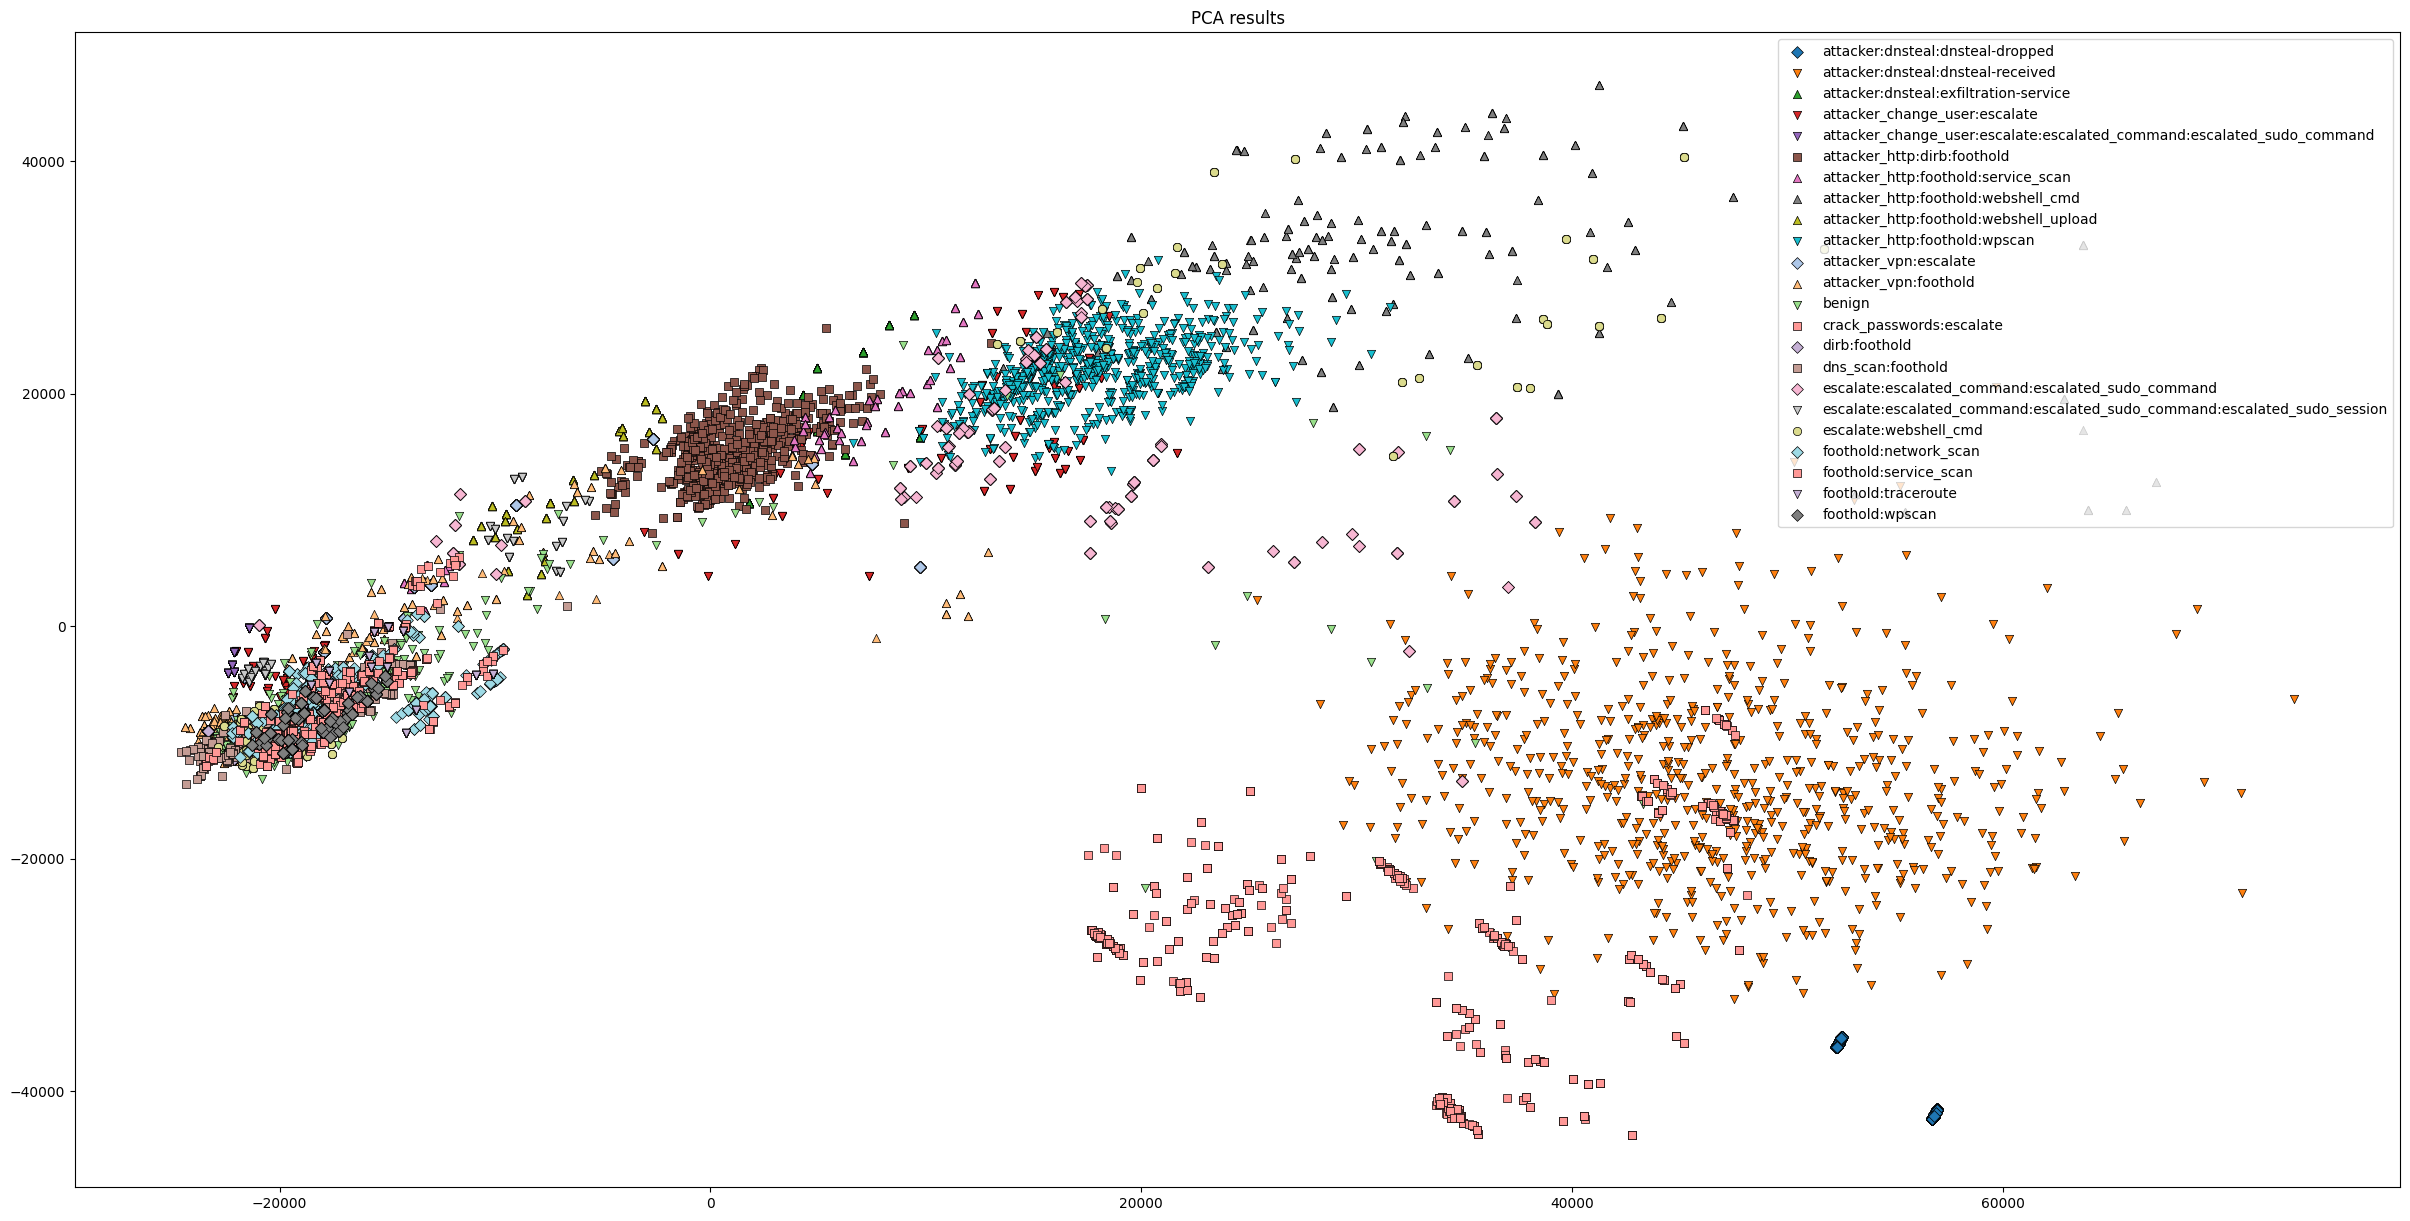

In [23]:
plot_2d_scatter(X_pca)

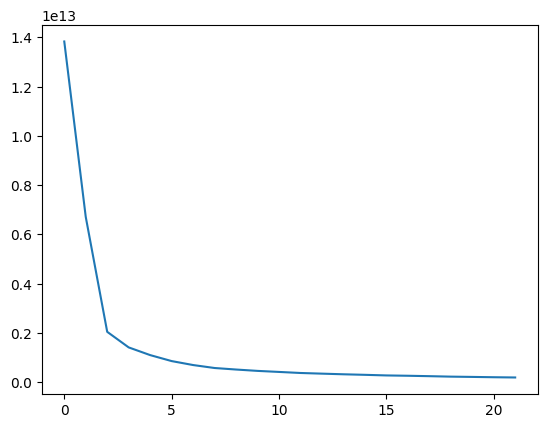

In [32]:
from sklearn.cluster import KMeans

inertia = []
n_classes = len(labels_df)
for i in range(1, n_classes):
    kmeans = KMeans(n_clusters=i, n_init=10)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
    
plt.plot(inertia)
plt.show()

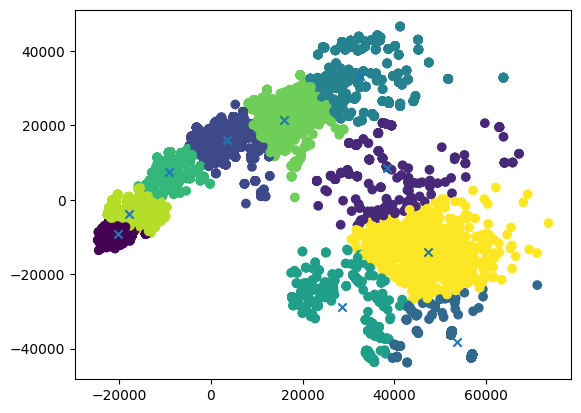

In [36]:
kmeans_final = KMeans(n_clusters=10, n_init=10).fit(X_pca)
centers = kmeans_final.cluster_centers_
labels = kmeans_final.labels_

plt.scatter(X_pca[:,0], X_pca[:,1], c=labels)
plt.scatter(centers[:,0], centers[:,1], marker='x')
plt.show()

In [50]:
!pip install plotly

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 15.6 MB 3.6 MB/s            


In [84]:
import plotly.graph_objects as go
import webbrowser

def save_3d_plot_html(data):
    #with html saved, download it and open in a browser
    fig = go.Figure()
    x,y,z = (data[:,0],data[:,1],data[:,2])
    
    for i, g in enumerate(np.unique(targets)):
        idx = np.where(targets==g)
        labelname = labels_df[labels_df['labelnum']==g]['labelname'].item()
        fig.add_trace(go.Scatter3d(x=x[idx], y=y[idx], z=z[idx], name=labelname))
        
    fig.update_layout(scene=dict(xaxis_title='X Label', yaxis_title='Y Label', zaxis_title='Z Label'),
                      title='3D Scatter Plot')
    fig.update_layout(hoverlabel=dict(bgcolor="black", font_size=16, namelength=-1))
    fig.write_html('3d_plot.html')


In [52]:
from mpl_toolkits.mplot3d import Axes3D

X_pca_3d = np.load(dim_folder+'/pca_3d_results.npy')


In [85]:
save_3d_plot_html(X_pca_3d)
